<a href="https://colab.research.google.com/github/Sirikanya-09/Stat2/blob/main/660510776_lab09_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [ ]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [ ]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


In [ ]:
X[0]

tensor([[[0.6863, 0.6941, 0.7020,  ..., 0.2980, 0.3098, 0.3176],
         [0.7020, 0.7020, 0.7020,  ..., 0.3020, 0.3098, 0.3176],
         [0.6824, 0.7020, 0.7098,  ..., 0.3098, 0.3137, 0.3176],
         ...,
         [0.3882, 0.3882, 0.3843,  ..., 0.1686, 0.1765, 0.1686],
         [0.3765, 0.3725, 0.3765,  ..., 0.1608, 0.1647, 0.1686],
         [0.3725, 0.3686, 0.3765,  ..., 0.1647, 0.1686, 0.1686]],

        [[0.5725, 0.5882, 0.6118,  ..., 0.1686, 0.1725, 0.1765],
         [0.5882, 0.6000, 0.6078,  ..., 0.1686, 0.1725, 0.1765],
         [0.5725, 0.6078, 0.6196,  ..., 0.1686, 0.1725, 0.1765],
         ...,
         [0.3961, 0.3922, 0.3882,  ..., 0.2078, 0.2118, 0.2118],
         [0.3843, 0.3804, 0.3843,  ..., 0.2039, 0.2039, 0.2118],
         [0.3765, 0.3765, 0.3843,  ..., 0.2000, 0.2039, 0.2078]],

        [[0.4157, 0.4314, 0.4706,  ..., 0.0980, 0.0902, 0.0863],
         [0.4196, 0.4510, 0.4784,  ..., 0.0980, 0.0941, 0.0902],
         [0.4000, 0.4471, 0.4902,  ..., 0.0902, 0.0941, 0.

In [ ]:
y

tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

#### Visualize the first four images in the batch

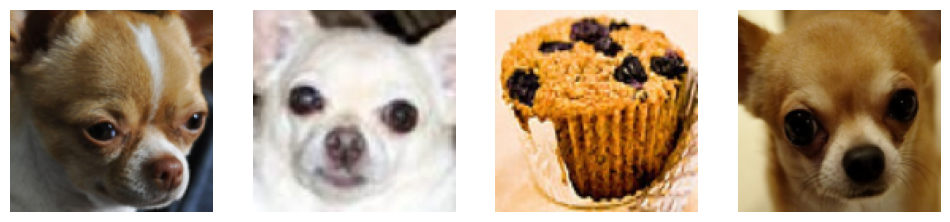

tensor([0, 0, 1, 0])


In [ ]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [ ]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(3 * 128 * 128, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x


### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [ ]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [ ]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [ ]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [ ]:
x,y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [ ]:
y_hat = model(x)
y_hat = y_hat[:, 0]
y = y.to(torch.float32)



#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [ ]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

In [ ]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [ ]:
for param in model.parameters():
  print(param.grad)

tensor([[-0.0659, -0.0651, -0.0659,  ..., -0.0296, -0.0288, -0.0278]])
tensor([0.])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [ ]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.6964741349220276]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

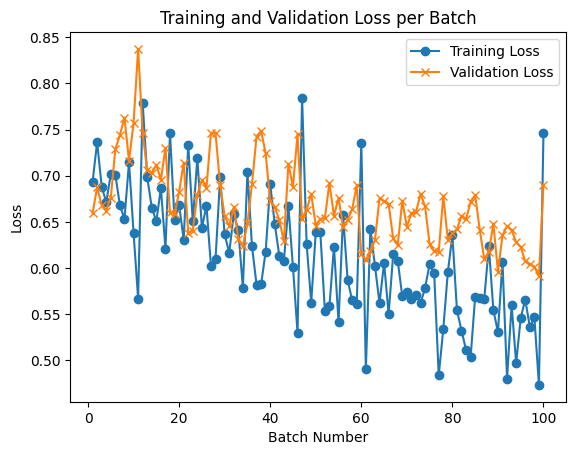

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [ ]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


In [ ]:
class ThreeLayerNet(nn.Module):
  def __init__(self):
    super(ThreeLayerNet, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(3 * 128 * 128, 128)  # First hidden layer
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, 64)  # Second hidden layer
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(64, 32)  # Third hidden layer
    self.relu3 = nn.ReLU()
    self.fc4 = nn.Linear(32, 1)  # Output layer
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    x = self.relu3(x)
    x = self.fc4(x)
    x = self.sigmoid(x)
    return x

In [ ]:
def train_and_evaluate(model, criterion, train_loader, val_loader, learning_rate, num_epochs):

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for X, y in train_loader:
      # Forward pass
      y_hat = model(X)
      y_hat = y_hat[:, 0]
      y = y.to(torch.float32)

      # Calculate training loss
      loss = criterion(y_hat, y)
      train_losses.append(loss.item())

      # Backward pass and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
      for X, y in val_loader:
        # Forward pass
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)

        # Calculate validation loss
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss.item())

  return train_losses, val_losses

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
all_train_losses = {}
all_val_losses = {}
criterion = nn.BCELoss()
num_epochs = 10

for lr in learning_rates:
  model = ThreeLayerNet()
  train_losses, val_losses = train_and_evaluate(model, criterion, train_loader, val_loader, lr, num_epochs)
  all_train_losses[lr] = train_losses
  all_val_losses[lr] = val_losses

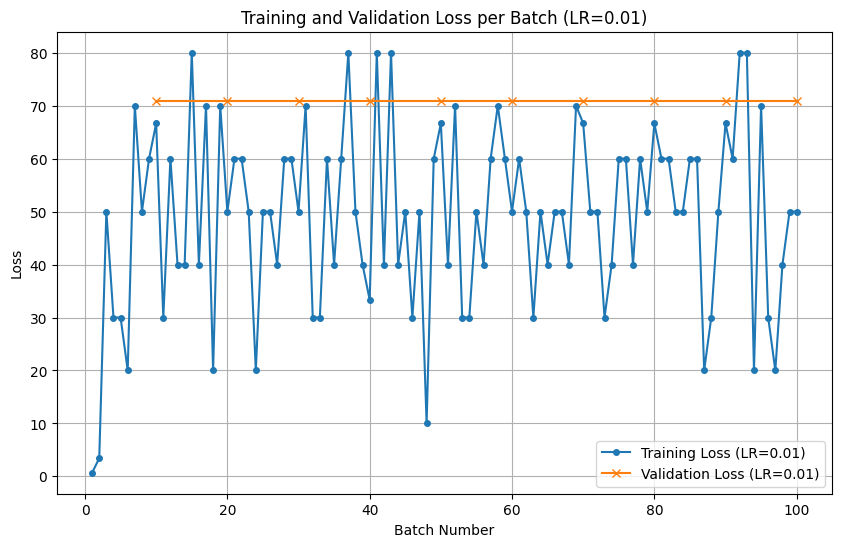

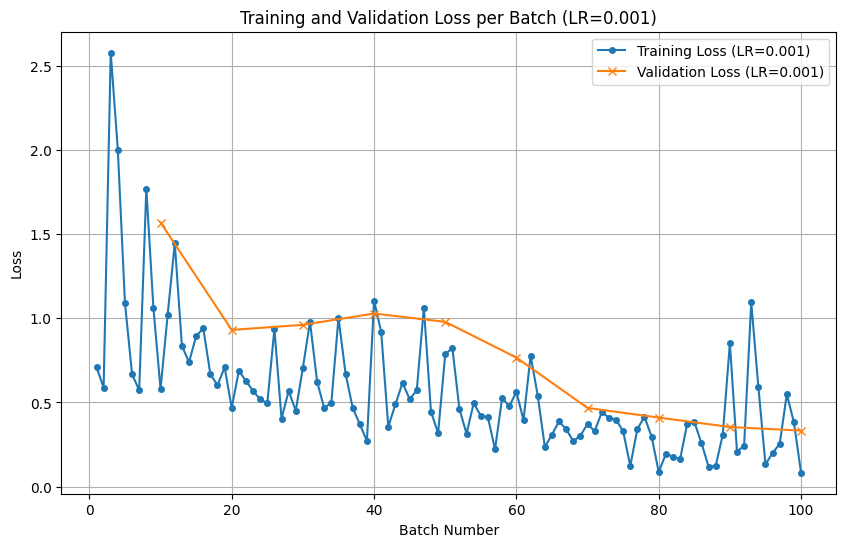

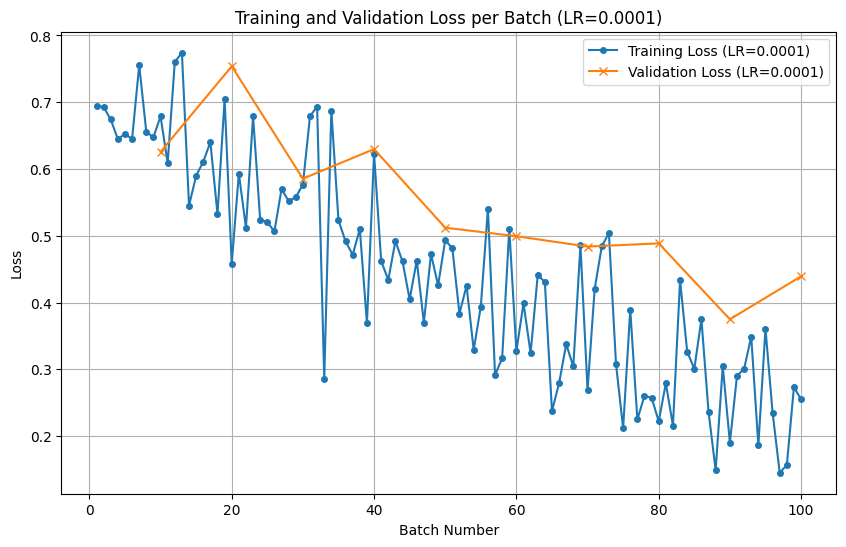

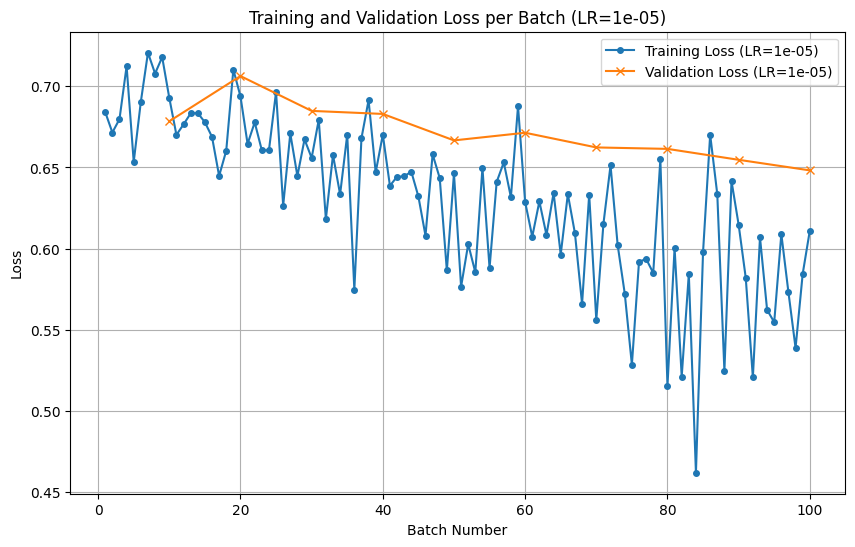

In [ ]:
num_epochs = 10 # Defined in the previous step, but for clarity, it's good to have it here as a reminder of how many epochs were run.
batches_per_epoch = len(train_loader)
batch_indices = np.arange(1, num_epochs * batches_per_epoch + 1)

for lr in all_train_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(batch_indices[:len(all_train_losses[lr])], all_train_losses[lr], marker='o', linestyle='-', markersize=4, label=f'Training Loss (LR={lr})')

    # Validation loss is recorded once per epoch, so we need to adjust the x-axis for plotting
    val_batch_indices = np.arange(batches_per_epoch, num_epochs * batches_per_epoch + 1, batches_per_epoch)
    plt.plot(val_batch_indices, all_val_losses[lr], marker='x', linestyle='-', markersize=6, label=f'Validation Loss (LR={lr})')

    plt.title(f'Training and Validation Loss per Batch (LR={lr})')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
model = ThreeLayerNet()
criterion = nn.BCELoss()
learning_rate = 0.0001
num_epochs = 10

train_losses, val_losses = train_and_evaluate(model, criterion, train_loader, val_loader, learning_rate, num_epochs)

In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for X, y in test_loader:
    y_hat = model(X)
    y_hat = y_hat.squeeze()
    predicted = (y_hat > 0.5).float()
    total += y.size(0)
    correct += (predicted == y).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')

Accuracy of the model on the test images: 73.33%


In [ ]:

misclassified_indices = (predicted != y).nonzero(as_tuple=True)[0]


num_to_display = min(4, len(misclassified_indices))
display_indices = misclassified_indices[:num_to_display]


misclassified_images = X[display_indices]
true_labels = y[display_indices]
predicted_labels = predicted[display_indices]

misclassified_images = misclassified_images.numpy().transpose(0, 2, 3, 1)

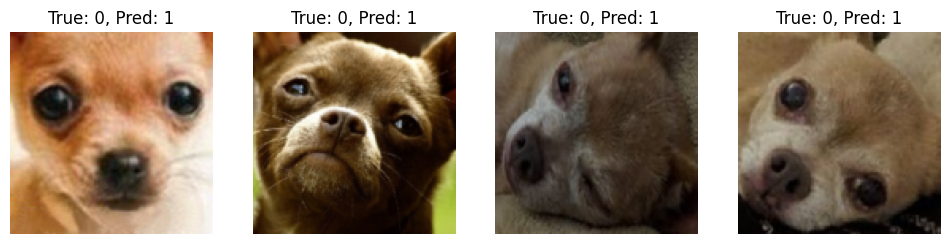

In [ ]:
# Plot misclassified images
fig, axes = plt.subplots(1, num_to_display, figsize=(12, 4))
for i in range(num_to_display):
    axes[i].imshow(misclassified_images[i])
    axes[i].set_title(f'True: {int(true_labels[i])}, Pred: {int(predicted_labels[i])}')
    axes[i].axis('off')
plt.show()